# GRAFICI DELLE MISURAZIONI 

Commenti validi per tutti i grafici: 
- ogni punto è la media su *30 osservazioni*
- con Kubernetes, intendo le misurazioni fatte con calico come CNI plugin


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# Files utilizzati
baremetal_array_fn: str = "./baremetal-no-ssl_arrays.csv"
baremetal_dataf_fn: str = "./baremetal-no-ssl_dataframes.csv"
# baremetal_array_fn: str = "./baremetal-with-ssl_arrays.csv"
# baremetal_dataf_fn: str = "./baremetal-with-ssl_dataframes.csv"
kube_array_fn: str = "./kube_arrays.csv"
kube_dataf_fn: str = "./kube_dataframes.csv"

In [25]:
def plot_rate(
    baremetal:  pd.DataFrame,
    kube:       pd.DataFrame,
    function:   str  = "",
    ideal_case: bool = True,
    y_quantity: str  = "rate_mean"
):
    # Extract the needed data: 
    kube = kube[kube["name"] == function].copy()
    baremetal = baremetal[baremetal["name"] == function].copy()
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(baremetal['n'], baremetal[y_quantity], label = "bare-metal", marker="o")
    plt.plot(kube['n'], kube[y_quantity], label = "kubernetes", marker="^")

    if ideal_case:
        plt.plot(baremetal['n'], baremetal[y_quantity].iloc[0] * baremetal['n'] / baremetal['n'].iloc[0], label = "Ideal case", linestyle = "--")
        
    plt.xlabel('Number of cores')
    plt.ylabel('Rate (Mb/s)')
    plt.title(f'{function} rate')
    plt.legend()
    
    plt.show()

## CASO 1 - ARRAY 

In [26]:
baremetal: pd.DataFrame = pd.read_csv(baremetal_array_fn)
kube:      pd.DataFrame = pd.read_csv(kube_array_fn)

In [27]:
# Le funzioni considerate nel benchmark sono: 
print(kube['name'].unique())

['block-wise operation' 'create random 2D-array' 'elementwise computation'
 'random access' 'reduction (std) along axis' 'reduction operation (std)'
 'sum the transpose']


#### 1.1 `block-wise operation`

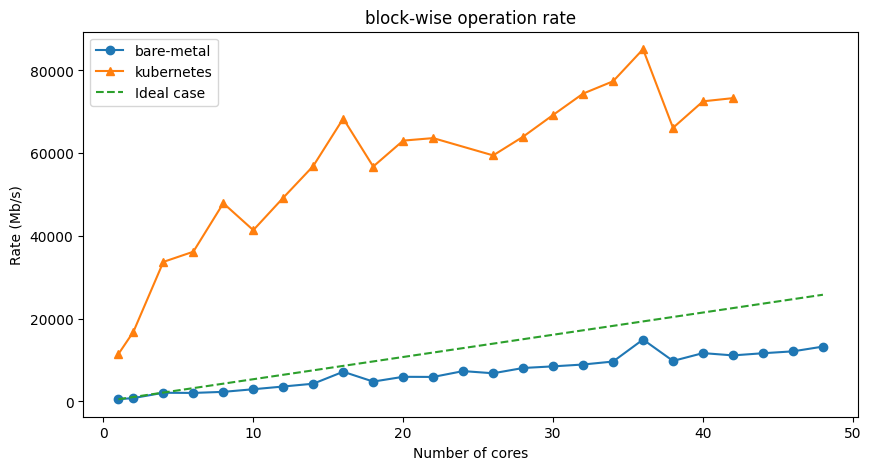

In [6]:
plot_rate(baremetal, kube, "block-wise operation")

Questo è l'unico grafico sorprendente e difficile da commentare della sezione array.

In questo benchmark quello che si sta facendo è 
- inizializzare un array bidimensionale, di dimensione `N = PROBLEM_SIZE_ARRAY * sqrt(n_cores)` in modo distribuito con dask
- distribuirlo in chunk quadrati  di lato `N/sqrt(n_cores)`
- per ogni elemento dell'array calcolare `x = x+1`

Per qualche ragione Kubernete sha risultati che out-performano il caso baremetal, e le misure sono consistenti anche su calico e flannel.

### 1.2 `create random 2D-array`

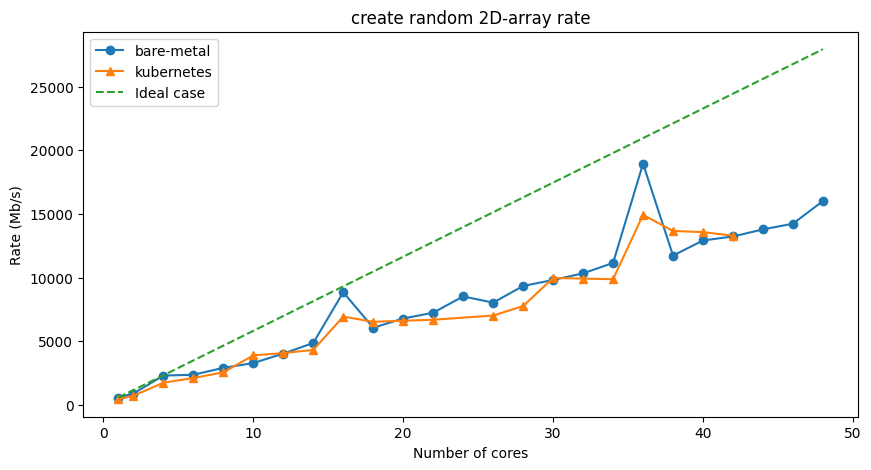

In [7]:
plot_rate(baremetal, kube, "create random 2D-array")

Non ci sono grandi problemi, qui avviene la creazione dell'array come descritta sopra:
- inizializzare un array bidimensionale, di dimensione `N = PROBLEM_SIZE_ARRAY * sqrt(n_cores)` in modo distribuito con dask
- distribuirlo in chunk quadrati  di lato `N/sqrt(n_cores)`

di fatto non c'è comunicazione, visto che ogni container si deve solamente generare i valori randomicamente per la propria porzione di chunks

 ### 1.3 `elementeise computation`

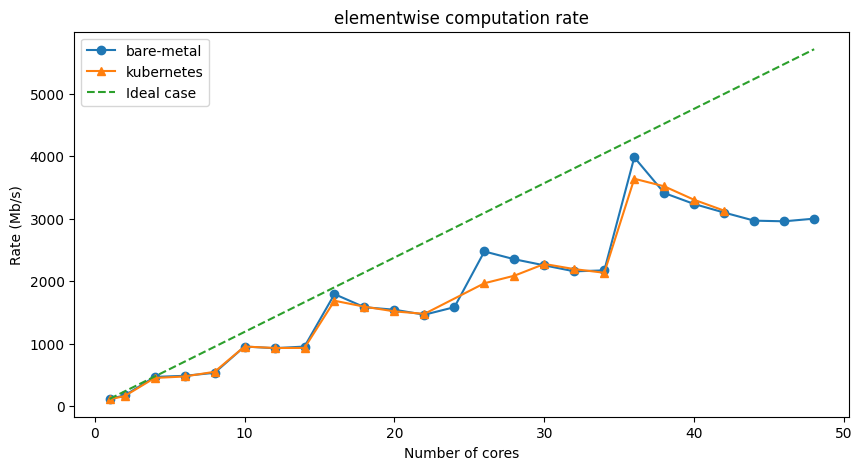

In [8]:
plot_rate(baremetal, kube, "elementwise computation")


Il principio è assolutamente identico a quello del caso `1.1 blockwise operation`. 
Anche in questo caso Si itera per ogni elemento dell'array e si modifica uno ad uno. le uniche due differenze sono: 

- L'operazione è più complessa: `x = cos(x)**2  + sin(x)**2`
- Non si è usato la funzione `dask.arrays.map_blocks()` per applicare una funzione blocco per blocco
- Si è invece creato un nuovo array (prima la modifica era in loco) per il risultato

In ogni caso, questo è il classico grafico che ci aspettiamo di vedere, dove i due scenari performano praticamente allo stesso modo. 

 ### 1.4 `random access` 

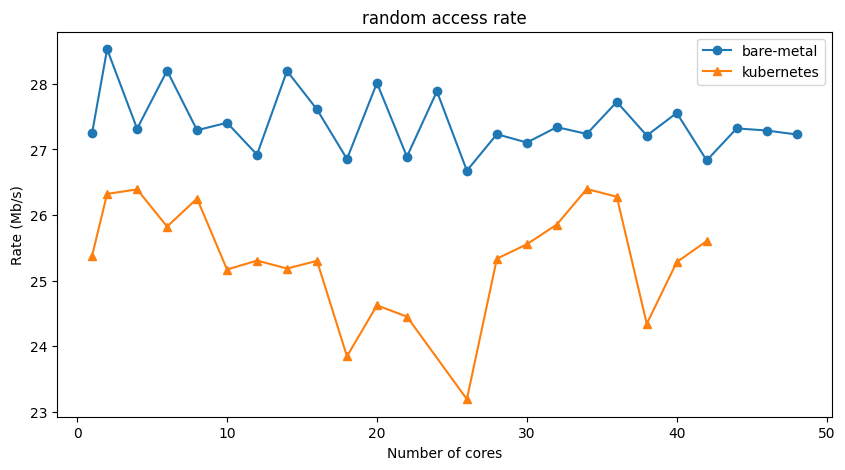

In [9]:
plot_rate(baremetal, kube, "random access", ideal_case=False)

Misurazione del tempo necessario per leggere il valore di una posizione hardcodata all'interno dell'array. 
CI si aspetta che rimanga costante, visto che non è un operazione di calcolo intensivo, il nodo che ha il chunk con la posizione interessata deve solo leggere e comunicare quel valore. 

La differenza di performance potrebbe tranquillamente essere giustificata dalla latenza maggiore che ci mette il worker a comunicare con lo scheduler (soprattutto considerano che lo scheduler era sulla VM)

 ### 1.5 `Reduction` 

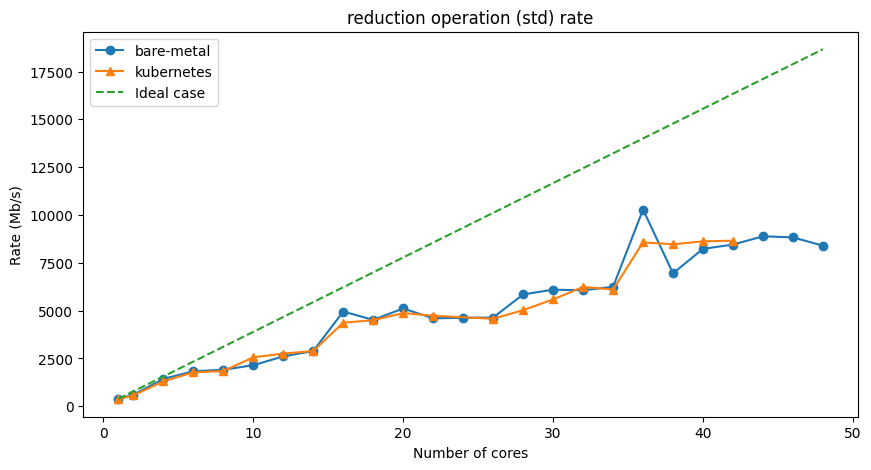

In [10]:
plot_rate(baremetal, kube, "reduction operation (std)")

l'operazione qui consiste nel calcolare un'operazione di riduzione (ho scelto la standard deviation solo perchè è più expensive dal punto di vista computazionale di media, massimo etc) di tutti i valori dell'array. 

La comunicazione è minima immagino perchè ogni nodo può calcolare i risultati parziali del proprio chunk senza dover communicare tutti i dati non necessari

### 1.6 `reduction operation along axis

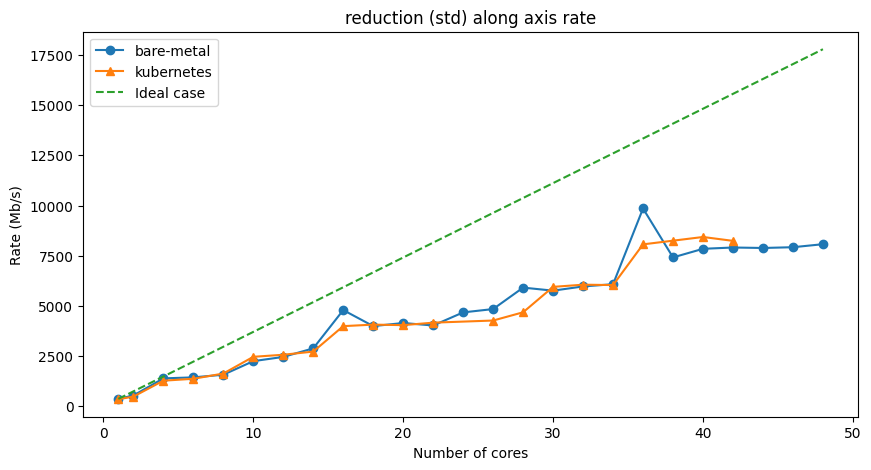

In [11]:
plot_rate(baremetal, kube, "reduction (std) along axis")

Caso analogo al precedente, solamente che anzichè avere la varianza dei valori dell'intera matrice, in questo caso viene calcolata la varianza di ogni riga individualmente. 
C'è quindi maggiore communicazione rispetto al caso precedente, ma come si può vedere, nulla di impattante

### 1.7 `sum the transpose`

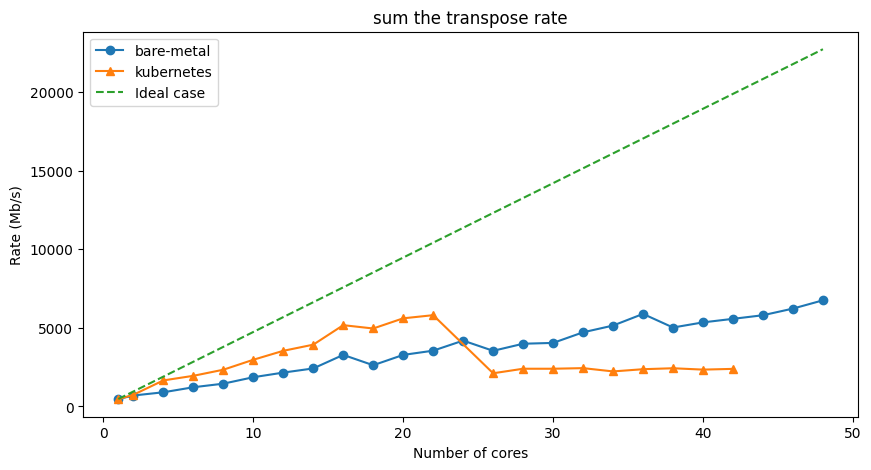

In [12]:
plot_rate(baremetal, kube, "sum the transpose")

Worst case scenario per la computazione parallela che vogliamo fare. 
In questo caso stiamo cercando di calcolare $B = A + A^T$
Ho volutamente scelto di usare la somma al posto dell prodotto per limitare la pesantezza di calcolo ed evidenziare il problema della rete. 

In questo caso la comunicazione massima, perchè ogni chunk deve essere comunicato al chunk simmetrico rispetto alla diagonale maggiore della matrice.  Si vede che fino a quando si rimane all'interno di un solo nodo (fino ai 22 core) allora le performance sono equiparabili. Appena si rende necessaria la communicazione node-to-node allora si ha il drop di performance. Cilium è quello che si difende "meglio" ma la differenza rispetto al caso bare-metal è evidente

## CASO 2 - DATAFRAMES

In [13]:
baremetal: pd.DataFrame = pd.read_csv(baremetal_dataf_fn)
kube:      pd.DataFrame = pd.read_csv(kube_dataf_fn)

In [14]:
# Le funzioni considerate nel benchmark sono: 
print(kube['name'].unique())

['block-wise operation' 'create random dataframe'
 'group-by apply operation' 'group-by operation'
 'group-by operation (2 columns)' 'order data' 'random access'
 'reduction operation (std)' 'series reduction operation (std)']


### 2.1 `block-wise operation`

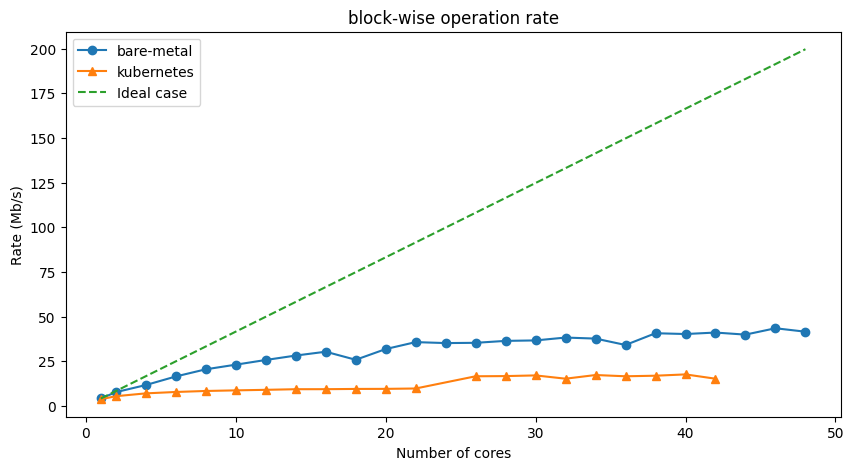

In [15]:
plot_rate(baremetal, kube, "block-wise operation")

applica a ogni elemento del dataframe l'operazione `x = x+1`, utilizzando le funzioni di dask `map_partitions`

Come in ogni altro grafico di questa sezione dedicata ai data frame osserviamo due cose:
- la scalabilità di dask con i data frame in generale non funziona
- Nel caso di kubernete parrebbe funzionare persino peggio.

La supposizione più probabile è che ci siano molte più componenti seriali nel codice e che ci sia molta più lavoro e comunicazione con lo scheduler

### 2.2 `create random dataframe`

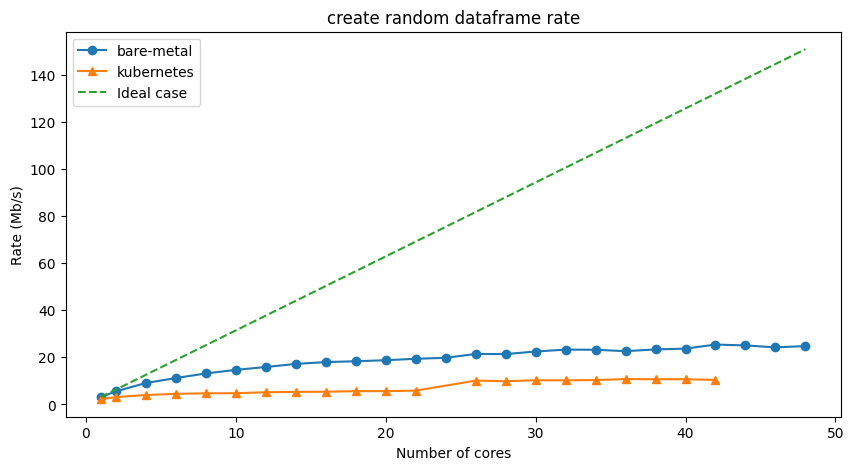

In [16]:
plot_rate(baremetal, kube, "create random dataframe")

Crea un dataframe di 6 colonne inizializzandolo con valori interi casuali nel range 0-10k.

### 2.3 `group-by operation`

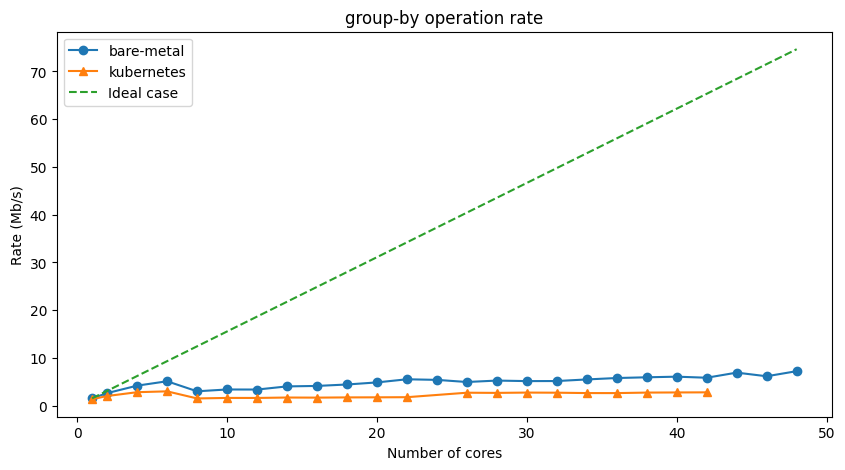

In [17]:
plot_rate(baremetal, kube, "group-by operation")

raggruppa tutte le righe che hanno lo stesso valore nella prima colonna, sostituendeole con una righa rappresentative di questa dove il valore di tutte le altre colonne è la media dei valori delle righe interessate dall'operazione

### 2.4 `group-by operation 2 columns`

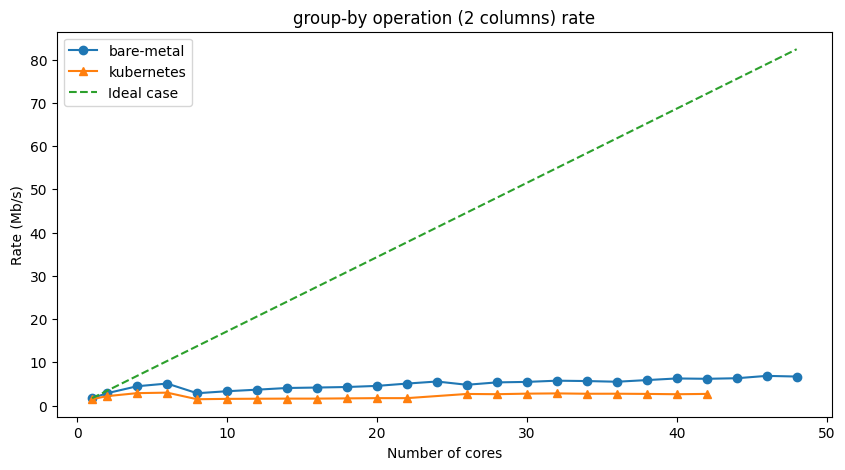

In [18]:
plot_rate(baremetal, kube, "group-by operation (2 columns)")

Stessa operazione descritta sopra, ma considerando una coppia di colonne come riferimento anzichè la singola 

### 2.5 `order data`

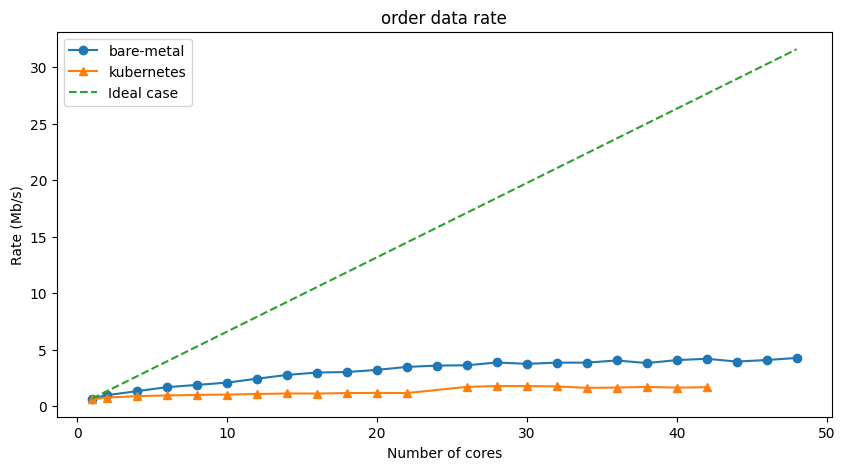

In [19]:
plot_rate(baremetal, kube, "order data")

Scambia di posizione tutte le righe in modo che i valori della colonna 1 siano ordinati in ordine crescente

### 2.6 `radnom access`

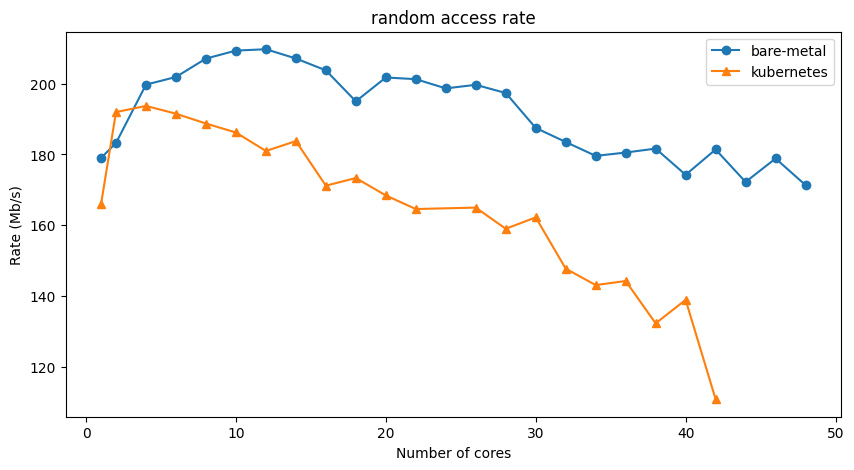

In [20]:
plot_rate(baremetal, kube, "random access", ideal_case=False)

Analogo al caso degli array; lettura di un valore ad una posizione hardcodata. 
si nota come il Rate dovrebbe rimanere costante, invece qui è in evidente calo per entrambe le situazioni misurate. 
Questo potrebbe essere dovuto a probabili hoverhead nella gestione degli oggetti di tipo DataFrame che sono più complessi

### 2.7 `reduction operation`

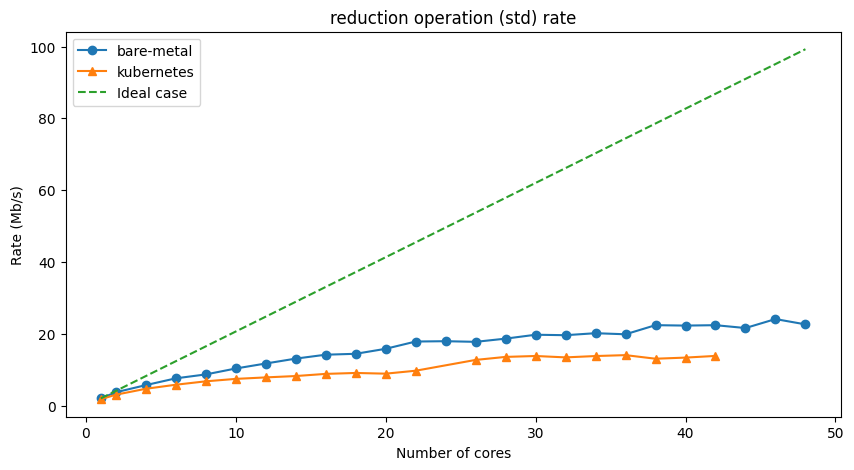

In [21]:
plot_rate(baremetal, kube, "reduction operation (std)")

Siccome la tabella era composta da soli valori numerici, ho provato anche a fare le stesse operazioni di riduzione che ho fatto con il caso degli Array bidimensionali. 
In qusto specifico caso, viene calcolata la varianza di tutti gli elementi presenti nella tablla

### 2.8 `series reduction operation`

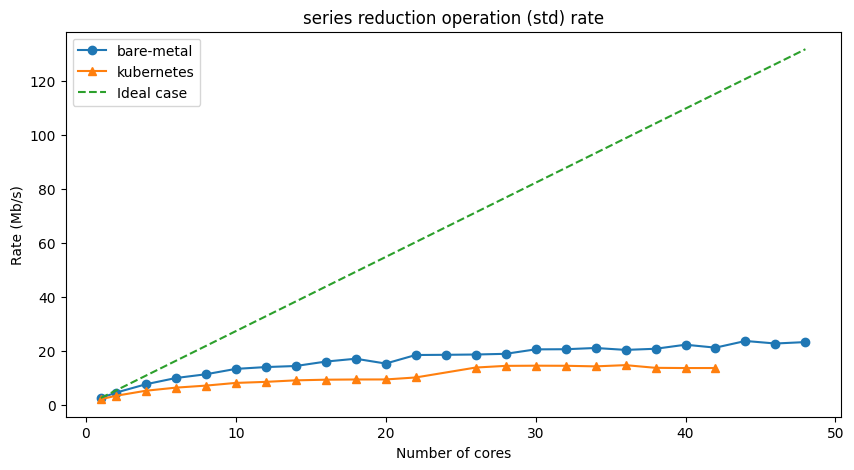

In [22]:
plot_rate(baremetal, kube, "series reduction operation (std)")

Simile a prima, ma in questo caso viene calcolata la varianza di una sola colonna 